In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import VBMicrolensing
import math
from event_rate import dif_event_rate#, integrand_jax,integrand_jax_m31, double_integral_2d
from astropy import units as u
from astropy import constants as C
from tqdm import tqdm

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20


%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'



In [2]:
import jax.numpy as jnp

def rE_jax(x,D,m):
    G = 6.67430e-11  # SI
    c_light = 299792458.0  # m/s
    k = 4 * G / c_light**2  # SI units
    return jnp.sqrt(k * m * D * x * (1 - x))
    
def tE_rho(x,m):
    kpc = 3.085677581491367e+19 # kpc in m
    
    R_sun =695700000.0 # R_sun in m
    km_s = 1000*60*60*24 # m/day
    
    D  = 770*kpc
    R_star = 1*R_sun
    vE = 200*km_s
    
    rE = rE_jax(x,D,m)
    tE = rE/(vE)
    rho = R_star*x/(rE) #1Rsun
    return tE, rho

def find_intersection_discrete(x_vals, y_vals, c):
    diff = y_vals - c
    sign_changes = jnp.where(jnp.sign(diff[:-1]) != jnp.sign(diff[1:]))[0]
    return x_vals[sign_changes]


import jax.numpy as jnp

def find_intersection(x_vals, y_vals, y_target):
    # Compute the difference from the target
    diffs = y_vals - y_target

    # Find sign changes
    signs = jnp.sign(diffs)
    sign_changes = signs[:-1] != signs[1:]

    # Indices where the sign changes (i.e., crossing happens)
    idx = jnp.where(sign_changes)[0]

    if len(idx) == 0:
        return -1  # No intersection found

    # For each crossing, interpolate linearly
    intersections = []
    for i in idx:
        x0, x1 = x_vals[i], x_vals[i+1]
        y0, y1 = y_vals[i], y_vals[i+1]
        
        # Linear interpolation formula
        slope = (y1 - y0) / (x1 - x0)
        x_intersect = x0 + (y_target - y0) / slope
        intersections.append(x_intersect)

    return intersections[0]

    
# print(tE) # day
# print(rho) # 
M_sun = 1.988409870698051e+30 # M_sun in kg
m = 1e-15*M_sun
x = 500/770
tE, rho = tE_rho(x,m)
print(tE, rho)

1.0344706321369498e-05 2527.19863604274


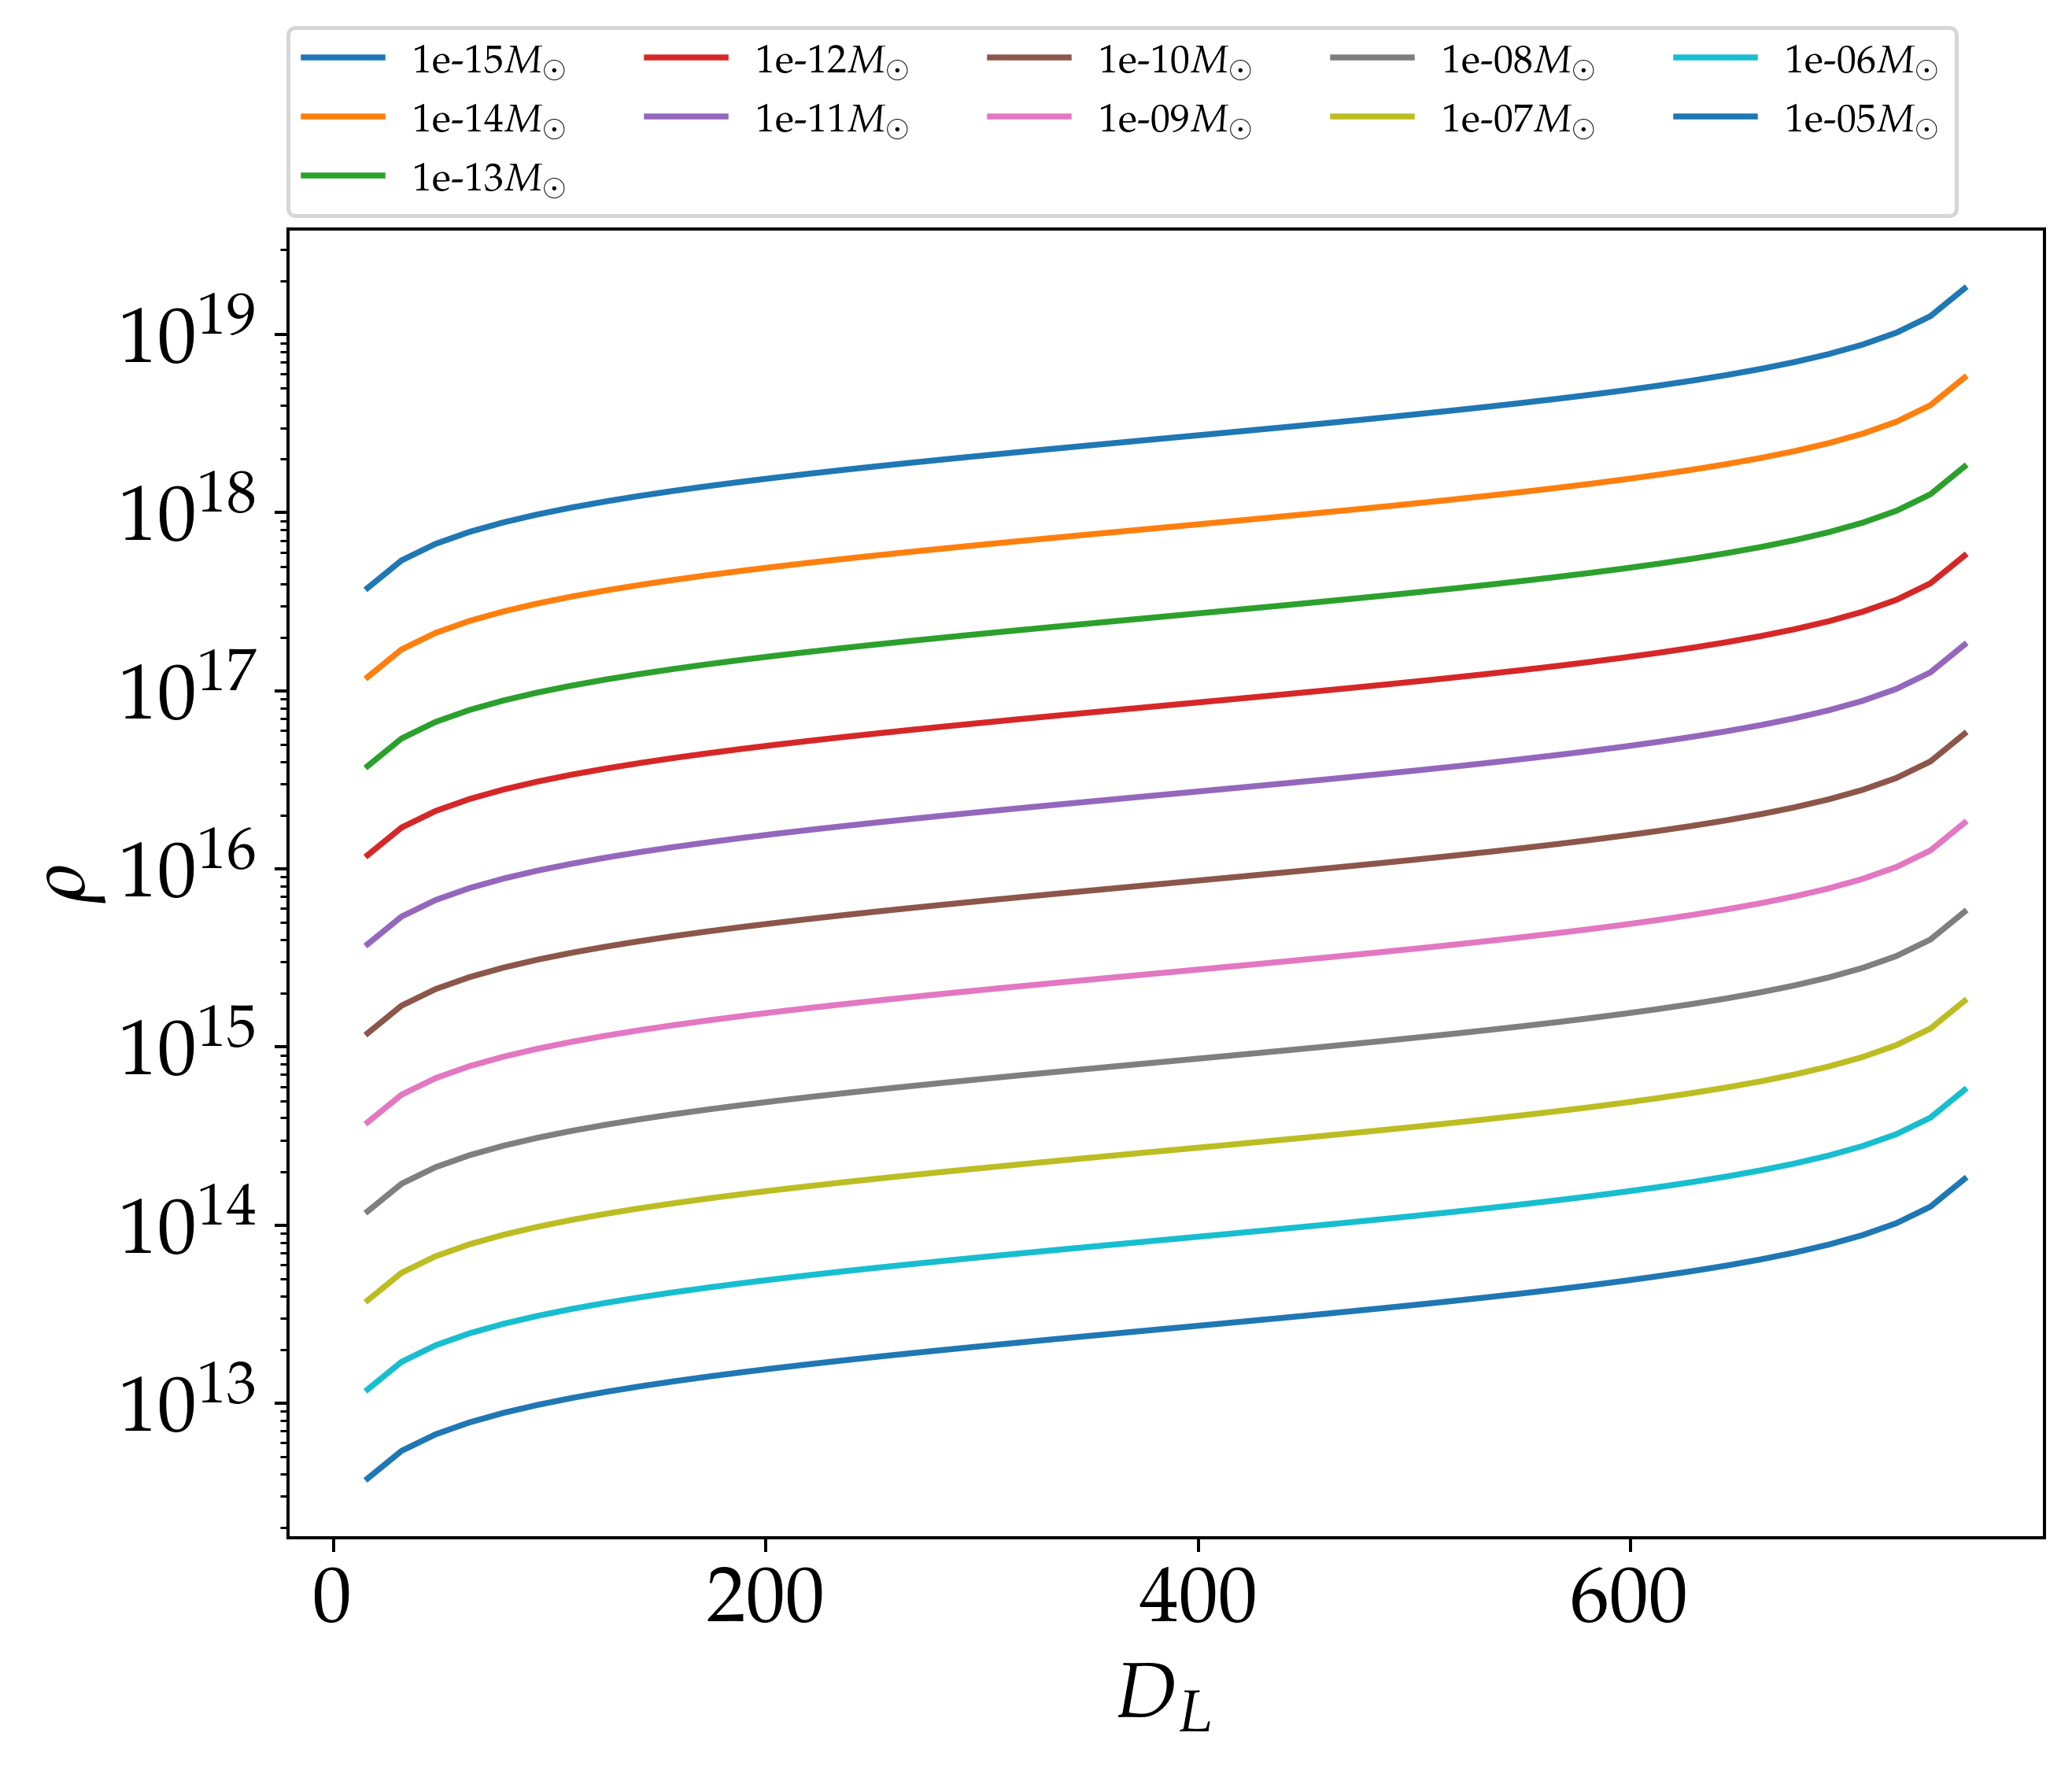

In [3]:
X = np.linspace(0,1)
plt.figure(figsize=(8,6),dpi=180)
for m in np.logspace(-15,-5,11):
    rhos = []
    for x in X:
        tE, rho = tE_rho(x,m)
        rhos.append(rho)
    plt.plot(X*770,rhos, label=str(m)+r"$M_{\odot}$")
plt.yscale('log')
plt.xlabel(r"$D_L$",fontsize=20)
plt.ylabel(r"$\rho$",fontsize=20)
plt.legend(loc=(0,1.01),ncols=5)
plt.show()

In [4]:
# M_sun = 1.988409870698051e+30 # M_sun in kg


# x = x_vals[3]
# m = 1e-10*M_sun
def uT_search(m, x):
    tE, rho = tE_rho(x,m)
    # print(tE, rho)
    # print(tE, rho)
    U0= np.linspace(0.01,3,100)
    
    t0 = 8550.4#, 100.3, 0.1  # Impact parameter, Time of closest approach, Einstein time, Source radius
    t = np.linspace(t0-5*tE, t0+5*tE,500)#t0+3*tE, 1000)  # Times at which we want to calculate the magnification
    A_max = []
    
    for u0 in U0:
        # Array of parameters
        pr = [math.log(u0),  # Note that we give some parameters in log scale
              math.log(tE),
              t0,
              math.log(rho)]
        # print(u0,tE,t0,rho)    
        VBM = VBMicrolensing.VBMicrolensing()
        VBM.SetLDprofile(VBM.LDquadratic)
        VBM.a1 = 0
        VBM.a2 = 0
        # VBM.a1 = 0.2  # Linear limb darkening coefficient.
        results = VBM.ESPLLightCurve(pr, t)  # Calculates the ESPL magnification at different times with parameters in pr
        A_max.append(max(results[0]))
    #     plt.plot(results[1], results[0],marker='.',label='Quadratic Limb Darkening')
    # plt.xlabel('u')
    # plt.ylabel(r'A')
    # plt.show()
    
    # plt.figure()
    # plt.plot(U0, A_max, '.' , ls='')
    # plt.axhline(1.34)
    # plt.yscale("log")
    # plt.show()
    amax = np.array(A_max)
    # print(U0[(1.34<amax)&(amax<1.345)])
    
    return find_intersection(np.array(U0), np.array(A_max), 1.34)

In [5]:
# X = np.linspace(1,150,1000)/770
m1 = 1e-10*M_sun
m2= 1e-11*M_sun
m3= 1e-12*M_sun
uT_1 = [-1]
uT_2 = [-1]
uT_3 = [-1]


In [6]:
# x = x_vals[10]
# x_vals = jnp.linspace(1e-9,1-1e-9, 10)
# X = np.logspace(-5,2,1000)/770
# m4= 1e-15*M_sun
# uT_0 = [500]

# for i,x in tqdm(enumerate(X)):
#     if uT_0[i]>1e-10:
#         uT_0.append(uT_search(m4, x))

    # uT_1.append(uT_search(m2, x))
    # uT_2.append(uT_search(m3, x))
    # uT_3.append(uT_search(m4, x))

In [7]:
# (np.logspace(-5, 2, 1000) / 770)[0]

In [8]:
# 1e-5/770

In [9]:
# np.logspace(-5, 2, 1000) / 770

# uT_search(1e-15 * M_sun, 1e-8)

# (np.logspace(-5, 2, 1000) / 770)[1]

In [10]:
# 10**(2.3123123)

In [11]:
# rho_test = 99
# pr = [math.log(0.0001),  # Note that we give some parameters in log scale
#       math.log(1),
#       666,
#       math.log(rho_test)]
# # print(u0,tE,t0,rho)    
# VBM = VBMicrolensing.VBMicrolensing()
# VBM.SetLDprofile(VBM.LDquadratic)
# VBM.a1 = 0
# VBM.a2 = 0
# # VBM.a1 = 0.2  # Linear limb darkening coefficient.
# t=np.array([665,666,667])
# results = VBM.ESPLLightCurve(pr, t)


In [12]:
# mass = 1e-15
# m4 = mass * M_sun
# # x = 0.0029
# # print(x*770)
# X = np.logspace(min_exp, np.log10(xf), 1000)

# print(uT_search(1e-7*M_sun, 2))
# for x in np.logspace(-9,2.88,1000):
#     tE, rho = tE_rho(x,m4)
#     if rho>99:
#         print(x)
#         break
    

In [13]:
# np.log10(0.0029457045745571466)
# np.logspace(min_exp, max_exp, 1000)

In [14]:
# 10**np.log10( 4e-14)

In [15]:
# for xf /

In [16]:
# np.logspace(-9, -0.0090, 1000)

In [17]:
# np.log10(9.79469667e-01)

In [18]:
# import numpy as np
# X = np.logspace(-9, 0, 1000)
# X


In [55]:
from tqdm import tqdm
import numpy as np


for mass in tqdm(np.logspace(-15,-5,100)): 
    uT_0 = [] 
    min_exp = -9  
    # mass = 1e-3 
    m4 = mass * M_sun 
    
    for xf in np.logspace(-9,0,2000):   
        tE, rho = tE_rho(xf,m4)  
        if rho>99: 
            # print(xf) 
            break 
    # print(np.log10(xf)) 
    if np.log10(xf)>-0.0090: 
        X = np.logspace(min_exp, -0.0090, 2000)# / 770    
        # print('here') 
    else: 
        X = np.logspace(min_exp, np.log10(xf), 2000)# / 770
        
    for i, x in enumerate(X):
        # print(x)
        new_uT = uT_search(m4, x)
        # Stop if the new value is too small
        if new_uT < 0:
            # print(f"Stopped at index {i}, x = {x:.3e}")
            break
    
        uT_0.append(new_uT)

    if i == 999:
        np.savez('/home/anibal-pc/figures_final_makler/u_t_baja_precision/uT_1e-'+str(np.log10(mass))+'_NOT_LD', uT_0, X*770)
    else:
        np.savez('/home/anibal-pc/figures_final_makler/u_t_baja_precision/uT_1e-'+str(np.log10(mass))+'_NOT_LD', uT_0, X[:i]*770)


 20%|████████▍                                 | 20/100 [03:31<14:06, 10.58s/it]


KeyboardInterrupt: 

<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_5661/1767762694.py:2: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(X*770,uT_0,lw=3,label=r'$M_{PBH}='+str(mass)+'M_{\odot}$')


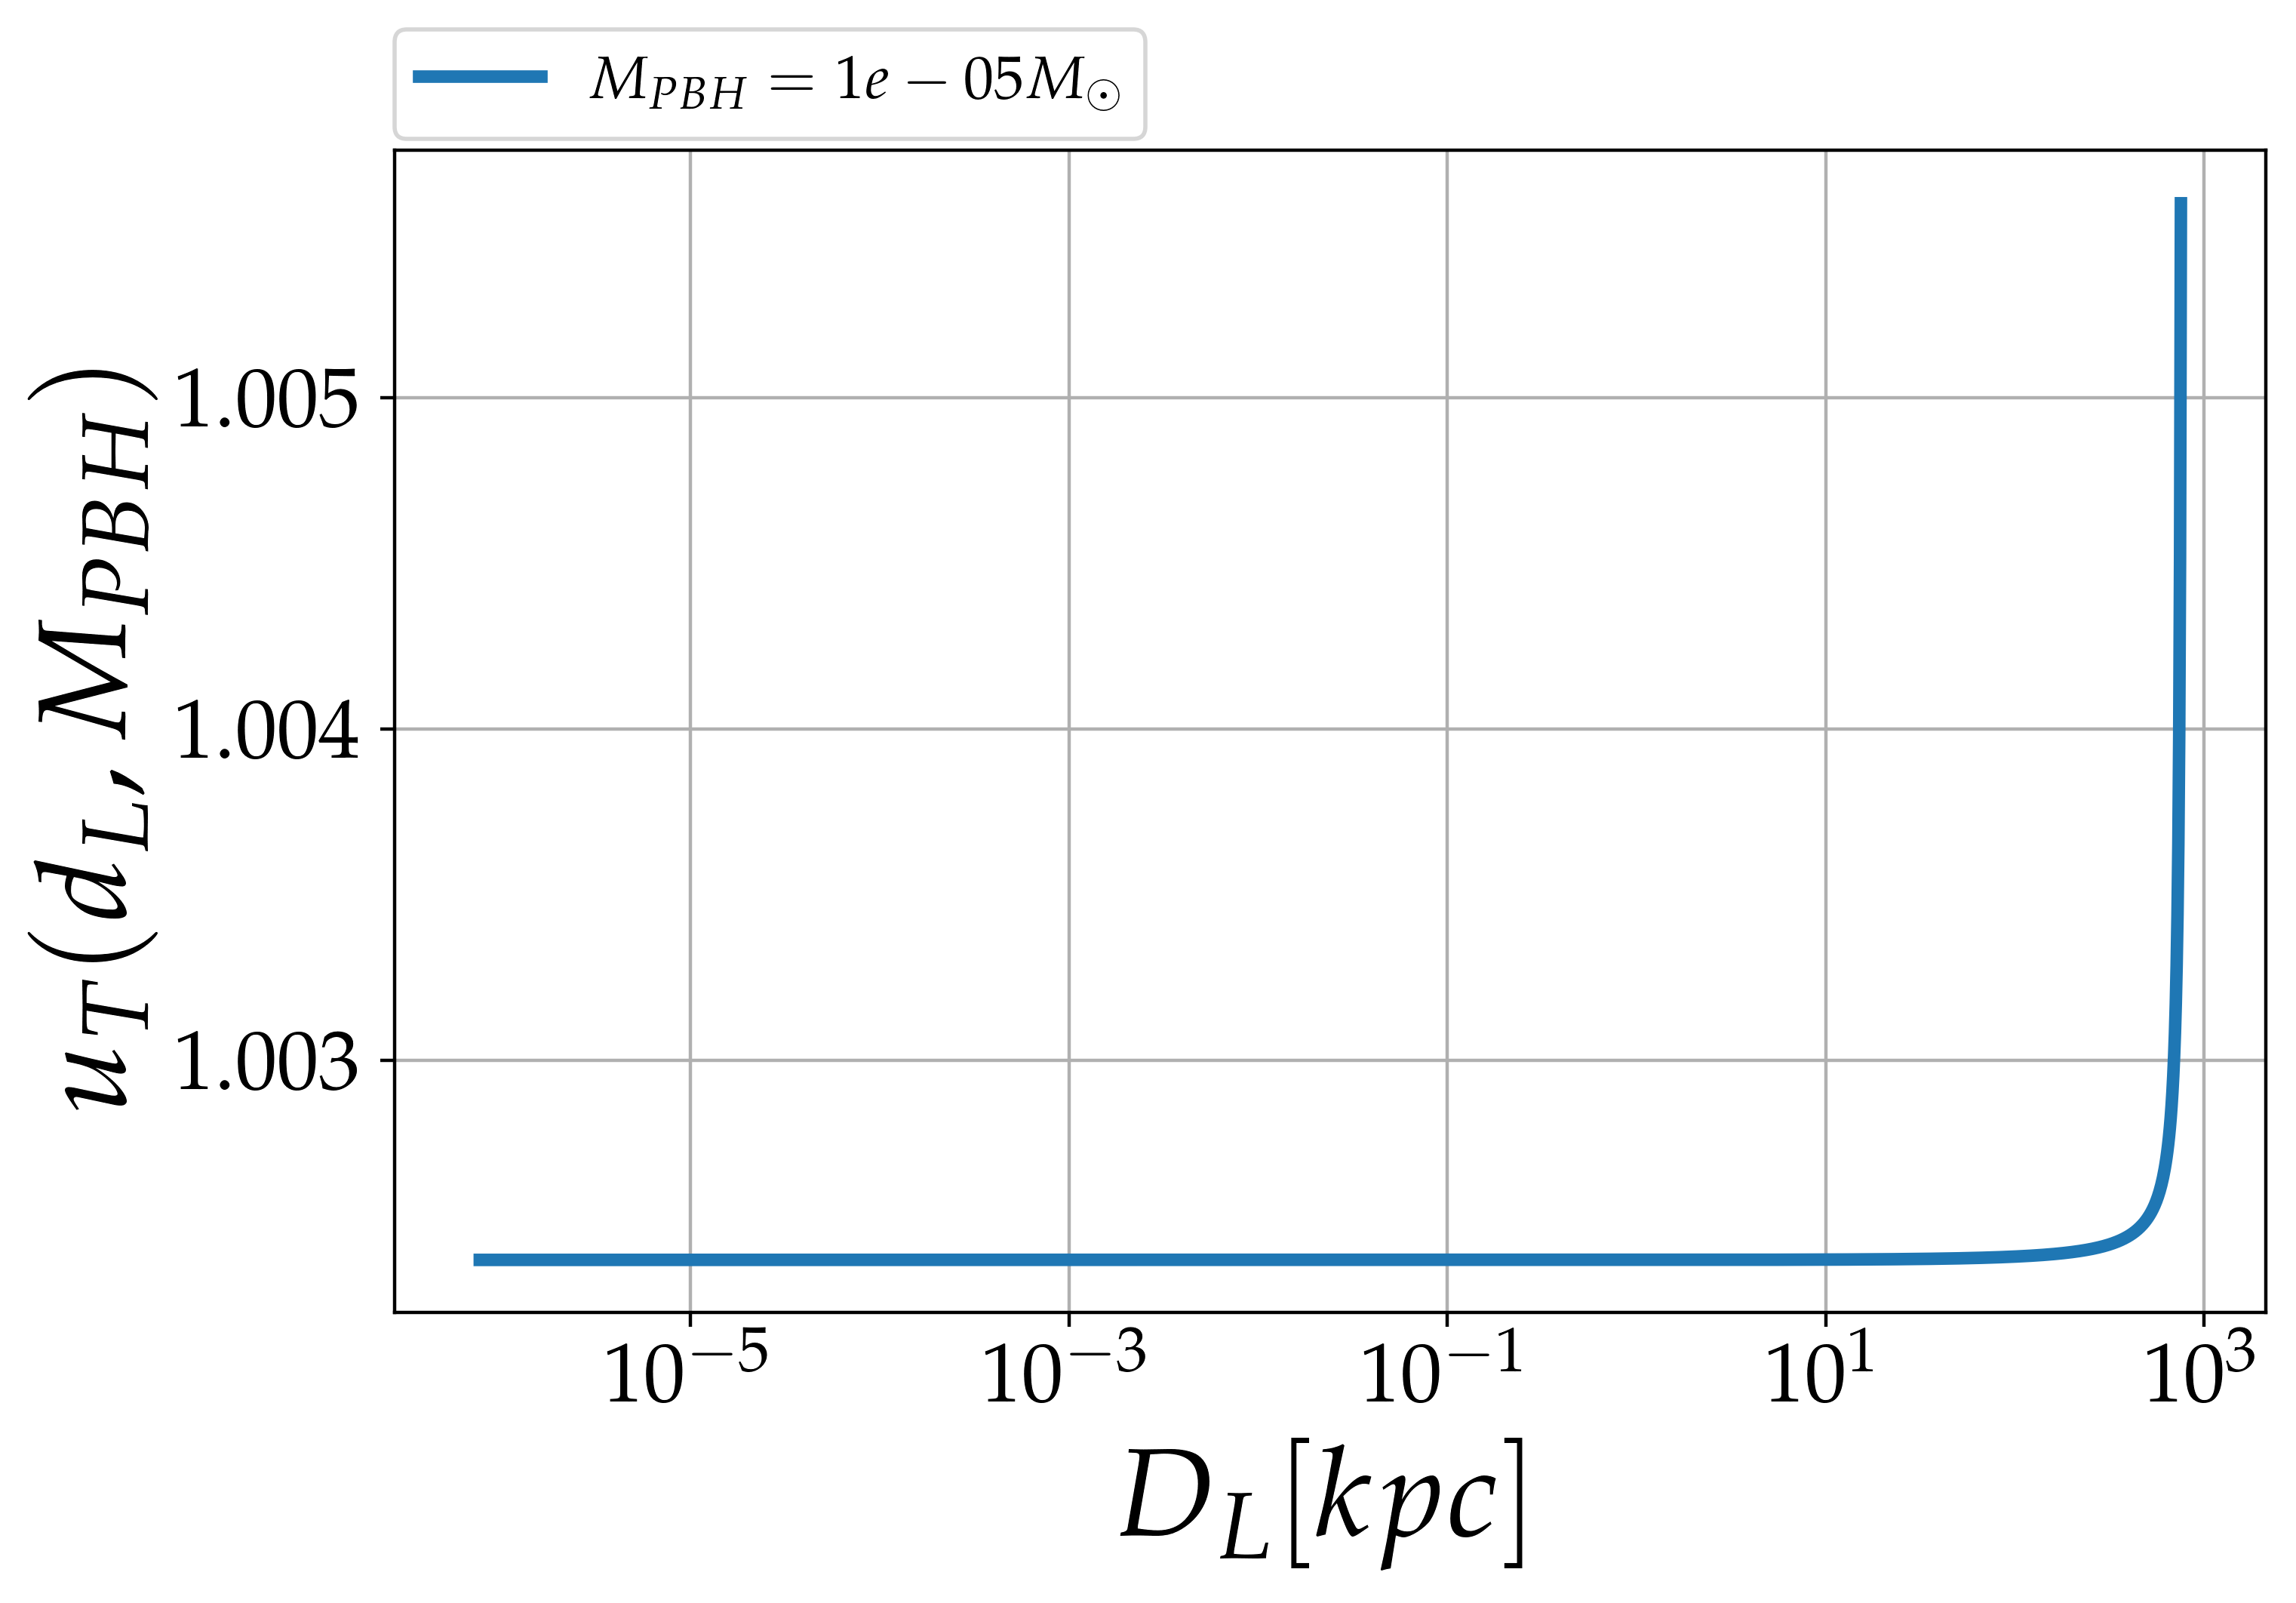

In [20]:
plt.figure(figsize=(8,5),dpi=200)
plt.plot(X*770,uT_0,lw=3,label=r'$M_{PBH}='+str(mass)+'M_{\odot}$')
# plt.plot(X*770,uT_1,lw=3,label=r'$M_{PBH}=10^{-11}M_{\odot}$')
# plt.plot(X*770,uT_2,lw=3,label=r'$M_{PBH}=10^{-12}M_{\odot}$')
# plt.plot(X*770,uT_3,lw=3,label=r'$M_{PBH}=10^{-15}M_{\odot}$')
# plt.ylim(0,2)
# plt.xticks([10,100,300,770],[10,100,300,770])
plt.xlabel(r"$D_L [kpc]$", fontsize=30)
plt.ylabel(r"$u_T(d_L, M_{PBH})$", fontsize=30)
plt.xscale("log")
plt.grid(True)
plt.legend(loc=(0,1.01),fontsize=14.5,ncols=2)
plt.savefig('/home/anibal-pc/figures_final_makler/u_T.png')
plt.show()


In [45]:
string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i]
ini = string.index('1e-')+3
fin = string.index('_NOT')
10**float(string[ini:fin])

7.3907220335257755e-09

0.41770251319343976
0.9590277320179129
here
1.002396957491619
0.15687529134068245
here
1.0023969575308957
0.11439534485076422
0.28359277009589373


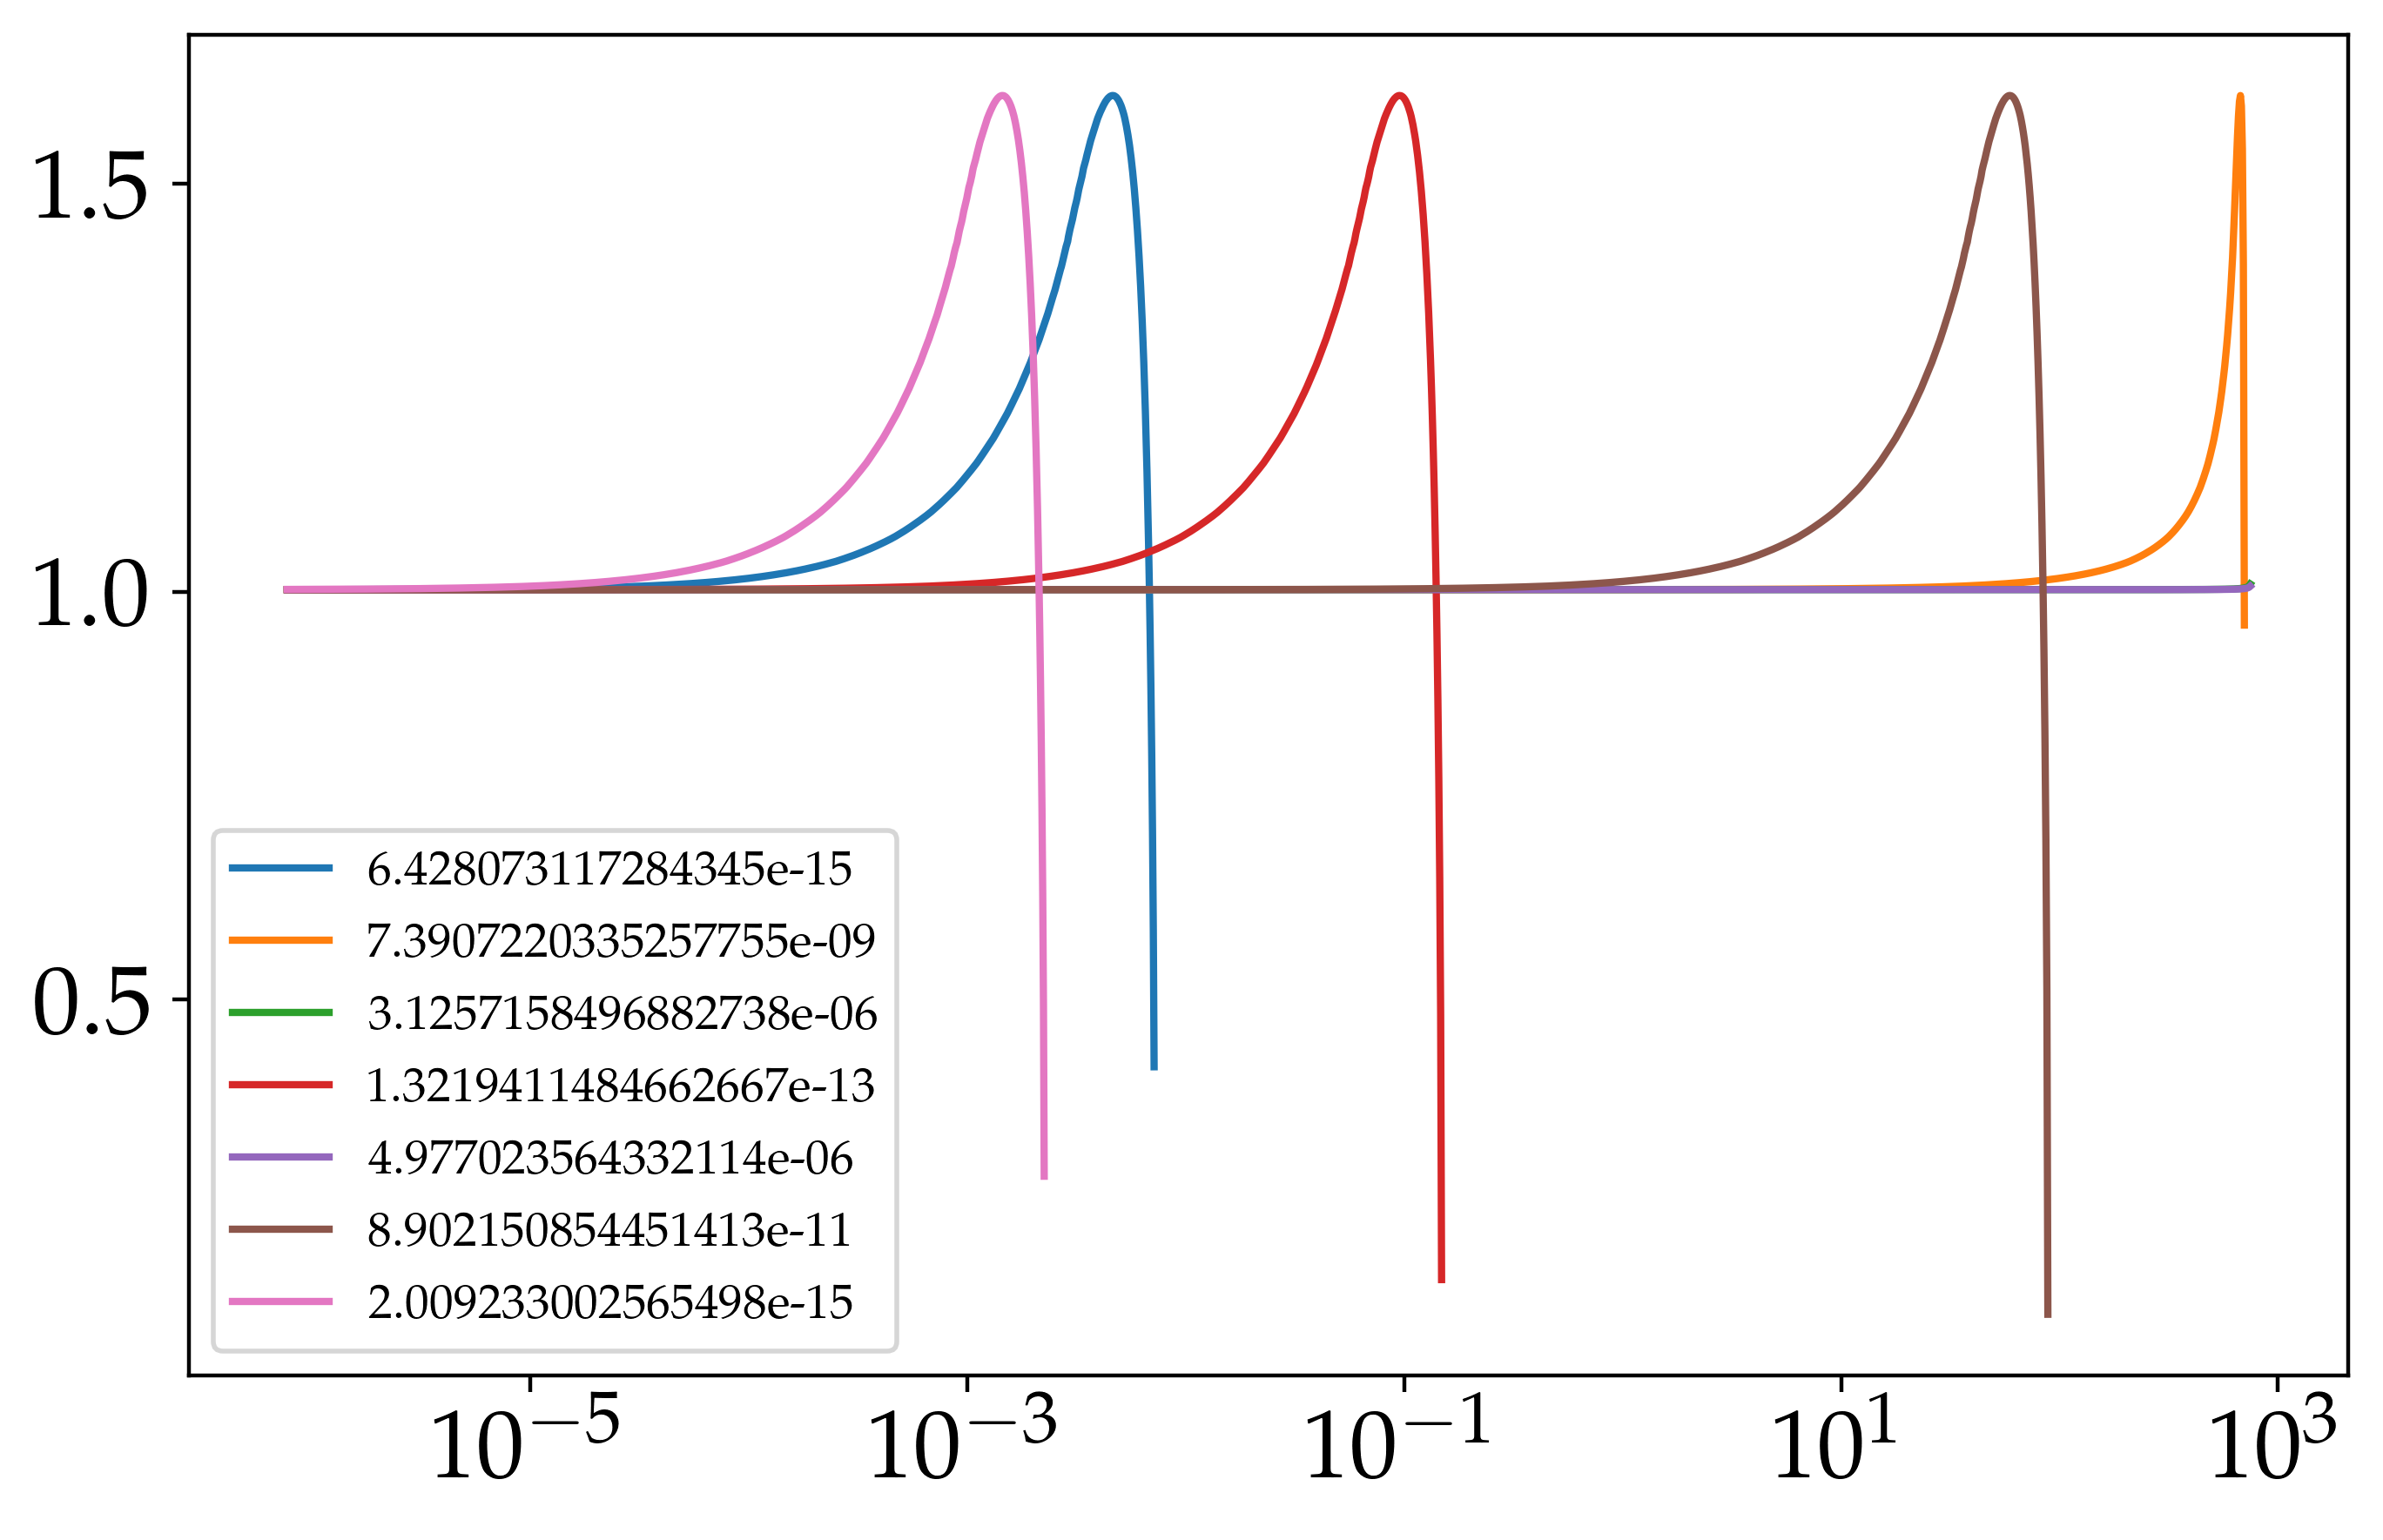

In [52]:
import os 
arr = [] 
plt.figure(figsize=(8,5),dpi=200)
for i in range(0,100,15): 
    string = os.listdir('/home/anibal-pc/figures_final_makler/uT_curves/')[i]
    arr0 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_0']
    arr1 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/'+string)['arr_1']
    
    # print(len(arr1),len(arr0))
    
    if len(arr1)==len(arr0):
        plt.plot(arr1,arr0,label = str(10**float(string[ini:fin-1])))
    elif not len(arr1)==len(arr0):
        print('here')
        plt.plot(arr1,arr0[:len(arr1)],label = str(10**float(string[ini:fin-1])))
    print(min(arr0))
    plt.xscale("log")
    ini = string.index('1e-')+3
    fin = string.index('_NOT')
    # arr.append(10**float(string[ini:fin]))
plt.legend(loc='best')
plt.show()
# print(np.sort(np.array(arr))==np.logspace(-15,5,100))

In [27]:
# arr0 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/uT_1e--14.0_NOT_LD.npz')['arr_0']
# arr1 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/uT_1e--14.0_NOT_LD.npz')['arr_1']
# plt.plot(arr1,arr0[0:558])
# plt.xscale("log")

# arr0 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/uT_1e--15.0_NOT_LD.npz')['arr_0']
# arr1 = np.load('/home/anibal-pc/figures_final_makler/uT_curves/uT_1e--15.0_NOT_LD.npz')['arr_1']

# plt.plot(arr1,arr0[:489])
# plt.xscale("log")
# plt.show()

$$I(\nu) = I(0) \left[1 - a1 (1 - \nu)- a2 (1-\nu)^2 \right]$$


In [28]:
# arr1

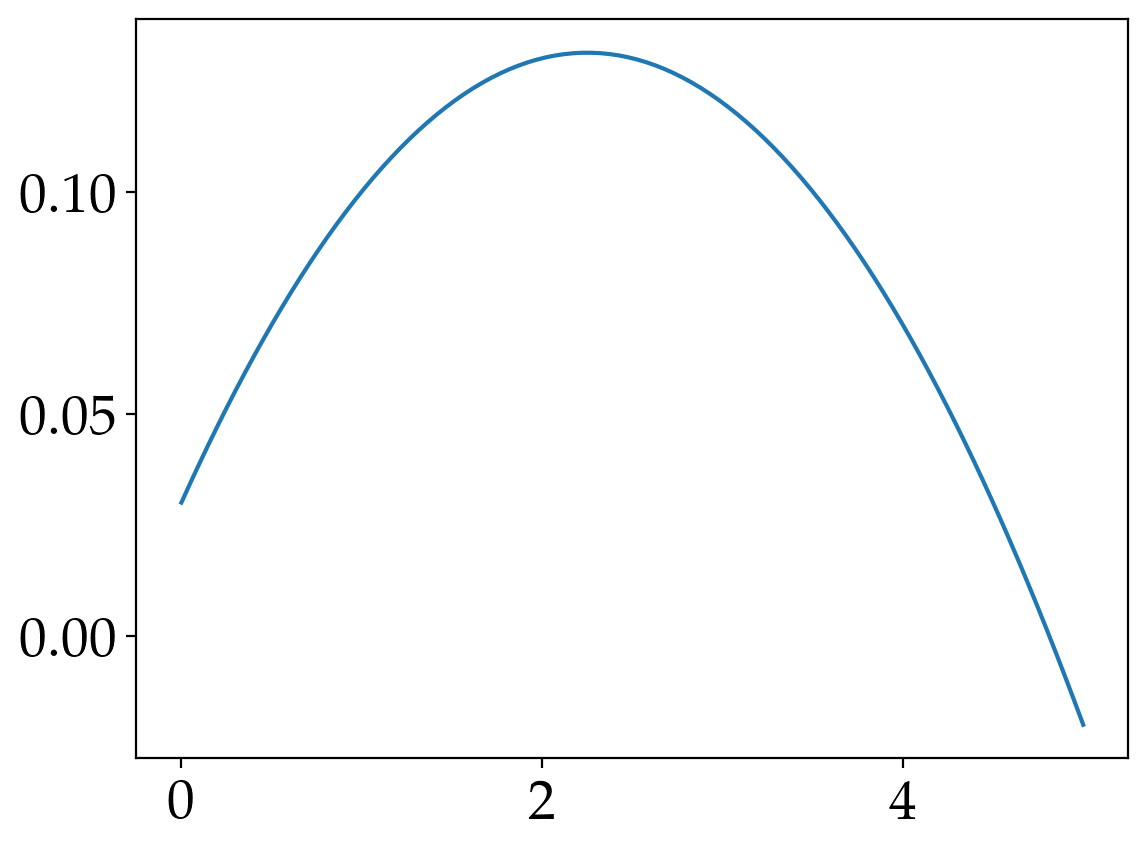

In [157]:
#profile Limb darkening

# $$I(\nu) = I(0) \left[1 - a1 (1 - \nu)- a2 (1-\nu)^2 \right]$$
a1 = 0.5
a2 = 0.2
I0=0.1
I = lambda nu: I0*(1-a1*(1-nu)-a2*(1-nu)**2)
nu=np.linspace(0,5,100)
plt.plot(nu, I(nu))
plt.show()